In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
#! pip install geopandas

In [121]:
import nltk
import csv
import numpy as np
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import os
import re
from functools import reduce
from tqdm import tqdm
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import heapq
import plotly.express as px
import geopandas as gpd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Search Engine

In [122]:
col_names = ['placeName', 'placeTags', 'placePeopleVisited',
       'placePeopleWant', 'placeDesc', 'placeShortDesc', 'placeNearby',
       'placeAddress', 'placeAlt', 'placeLong', 'placeEditors',
       'placePubDate', 'placeRelatedLists', 'placeRelatedPlaces',
       'placeURL']
df = pd.read_csv('/content/drive/MyDrive/ADM/Homework3/merged.tsv', sep='\t', names = col_names)
df = df.drop(0)

Preprocessing <br>


In addition to the points listed in the homework we decided to remove numbers because they don't carry any information. However, looking at the website, we see that many places are linked to a specific historical period (e.g. World War 2), so it might be a criterion a user takes into account when searching for a query. Due to this reason we leaved the dates, e.g. numbers of four digits that starts with a 1 or a 2. Then each year is converted in the corresponding century (1634 becomes 1600) since it is more likely to serch for a generic century rather than a specific date.  <br>
Of course not every four digit number is a year but we can claim that they are the vast majority. A simple but rough motivation for this is that, looking at the words frequencies, we can see how the word 'year' is one of the most common overall.

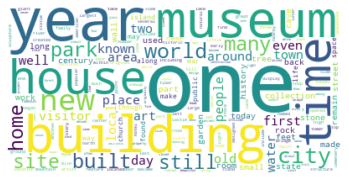

In [123]:
tokens = RegexpTokenizer(r'\w+')
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(' '.join([word.lower() for word in list(tokens.tokenize(df.placeDesc.sum())) if not word.lower() in stop_words]))
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [124]:
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def text_preprocessing(str):
  # remove punctuation and tokenize only words and numbers
  tokens = RegexpTokenizer(r'\w+')
  tokens = list(tokens.tokenize(str))
  # execute stemming
  tokens = [ps.stem(word.lower()) for word in tokens if not word.lower() in stop_words]
  # remove numbers and leave dates
  tokens = [el for el in tokens if not re.match(r'^\d{1,3}$|^[^12]{1}\d{3}$|^\d{5,}$', el)]
  # process dates
  tokens = list(map(lambda x: x[:2] + '00' if re.match(r'^\d+$', x) else x, tokens))
  # remove mixted string (letters and numbers)
  tokens = [el for el in tokens if re.match(r'^\d+$|^[a-z]+$', el)]
  return tokens

## 2.1. Conjunctive query

### 2.1.1) Create your index!

In [125]:
# CREATE VOCABULARY

# # apply the preprocessing to the place description
# df.placeDesc = df.placeDesc.apply(text_preprocessing)
# # compute vocabulary
# words_count = Counter(df.placeDesc.sum())
# total_words = sorted(list(set(words_count)))
# vocabulary = dict(zip(total_words, list(range(1, len(total_words) + 1))))

In [126]:
# SAVE VOCABULARY

# with open('/content/drive/MyDrive/ADM/Homework3/vocabulary.pkl', 'wb') as f:
#   pickle.dump(vocabulary, f)

In [127]:
# LOAD VOCABULARY

with open('/content/drive/MyDrive/ADM/Homework3/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

In [128]:
# COMPUTE INVERTED INDEX

# inverted_index = {}
# for word, index in tqdm(vocabulary.items()):
#   inverted_index[index] = list(df[df.placeDesc.apply(lambda x: word in x)].index)  

In [129]:
# SAVE INVERTED INDEX

# with open('/content/drive/MyDrive/ADM/Homework3/inverted_index.pkl', 'wb') as f:
#     pickle.dump(inverted_index, f)

In [130]:
# LOAD INVERTED INDEX

with open('/content/drive/MyDrive/ADM/Homework3/inverted_index.pkl', 'rb') as f:
    inverted_index = pickle.load(f)

### 2.1.2) Execute the query

In [131]:
# store inverted index into dataframe
inverted_index_df = pd.DataFrame(inverted_index.items(), columns = ['term_index', 'document'])

What we do is preprocess the query with the same function we used for the documents and then computing the intersection of all the posting lists corresponding to the tokens of the query.

In [132]:
query = 'american museum'
query = text_preprocessing(query)
query = [vocabulary[q] for q in query]
a, b = inverted_index_df[inverted_index_df.term_index.isin(query)].document.values
results = list(set(a) & set(b)) # document ids of the results

In [133]:
#display results
display = df.loc[results][['placeName', 'placeDesc', 'placeURL']]
display.head(10)

,placeName,placeDesc,placeURL
6656,Evel Knievel Museum,The Evel Knievel Museum takes you through the...,https://www.atlasobscura.com/places/evel-knie...
4097,McNutt Sculpture Garden,A hidden sculpture garden exists just off the...,https://www.atlasobscura.com/places/mcnutt-sc...
2561,The Wolfsonian-FIU,The Wolfsonian-Florida International Universi...,https://www.atlasobscura.com/places/wolfsonia...
6657,Old Time Wooden Nickel Company,"The adage goes, “don’t take any wooden nickel...",https://www.atlasobscura.com/places/old-time-...
1538,National Museum of Health and Medicine,"Once housed in downtown Washington, D.C., the...",https://www.atlasobscura.com/places/national-...
2054,Soumaya Museum,"Housing a whopping 66,000 pieces of predomina...",https://www.atlasobscura.com/places/soumaya-m...
4103,World's Largest Shuttlecocks,Across the expansive grounds of the Nelson-At...,https://www.atlasobscura.com/places/world-s-l...
5126,"Harriet Beecher Stowe, Slavery to Freedom Museum",This early brick Georgian townhouse sits inco...,https://www.atlasobscura.com/places/harriet-b...
1543,Rock Art Ranch,"Rock Art Ranch, near Winslow, Arizona, is a p...",https://www.atlasobscura.com/places/rock-art-...
3086,The Athenian Agora,Lying right beneath the northern slope of the...,https://www.atlasobscura.com/places/the-athen...


The results we obtain are not as good as we would. In fact, considering that many places on the website have in the title the words 'american' and 'museum', we see that none of our results have both of them in the title and just a few of them have at least one, which is 'museum', clearly dependent to the fact that it is one of the most common words (as we seen above).

## 2.2) Conjunctive query & Ranking score


### 2.2.1) Inverted index

In [134]:
#reload dataset
col_names = ['placeName', 'placeTags', 'placePeopleVisited',
       'placePeopleWant', 'placeDesc', 'placeShortDesc', 'placeNearby',
       'placeAddress', 'placeAlt', 'placeLong', 'placeEditors',
       'placePubDate', 'placeRelatedLists', 'placeRelatedPlaces',
       'placeURL']
df = pd.read_csv('/content/drive/MyDrive/ADM/Homework3/merged.tsv', sep='\t', names = col_names)
df = df.drop(0)

In [135]:
k = 10

We compute the df-idf using scikit-learn library.

In [136]:
model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)
tf_idf = model.fit_transform(df.placeDesc)

2.2.2) Execute the query

As before we give to the query the same treatment we gave to the documents, in this case computing the embedding, then we find all the documents that contains all the tokens of the query, then we compute the cosine similarity with respect to the query and, using a heap for efficiency, we find the top k documents. 

In [138]:
query = 'american museum'
query_vec = model.transform([query])
# find all documents that contains all queries
documents_with_all_query = reduce(np.intersect1d, tuple([np.nonzero(tf_idf[:, vocabulary[q] - 1].toarray())[0] for q in text_preprocessing(query)]))
# find similarities between query and all the documents
similarities = cosine_similarity(tf_idf, query_vec)
# case 1: number of results less than k
if len(documents_with_all_query) < k:
  similar_pages = enumerate(-similarities)
  similar_pages = [el[::-1] for el in similar_pages]
  heapq.heapify(similar_pages)
  k = len(np.nonzero(similarities))
else:
# case 2: otherwise 
  similar_pages = [(-similarities[b], b) for b in documents_with_all_query]  
  heapq.heapify(similar_pages)

In [139]:
# get top k documents
top_k_elements = []
for i in range(k):
  top_k_elements.append(heapq.heappop(similar_pages))

In [140]:
#display results
display = df.loc[[el[1] + 1 for el in top_k_elements]][['placeName', 'placeDesc', 'placeURL']]
display['scores'] = [-el[0][0] for el in top_k_elements]
display.head(k)

,placeName,placeDesc,placeURL,scores
141,Museum of the Weird,The dime or dime store museum is by all accou...,https://www.atlasobscura.com/places/museum-we...,0.298123
6204,Sweet Home Cafe,Thomas Downing was the oyster king. In 19th-c...,https://www.atlasobscura.com/places/sweet-hom...,0.292803
1199,Harvard Museum of Natural History,Collecting three different institutions into ...,https://www.atlasobscura.com/places/harvard-m...,0.283666
6220,Siriraj Medical Museum,The Siriraj Medical Museum abounds with medic...,https://www.atlasobscura.com/places/siriraj-m...,0.273827
4463,American Writers Museum,The American Writers Museum—tucked away on th...,https://www.atlasobscura.com/places/american-...,0.269401
2669,Milwaukee Art Museum,Like the Guggenheim in New York and the Oakla...,https://www.atlasobscura.com/places/milwaukee...,0.257663
6310,Self-Taught Genius Gallery,"In 2017, the American Folk Art Museum in Manh...",https://www.atlasobscura.com/places/self-taug...,0.250283
1904,National World War II Museum,"Perhaps once thought too narrowly focused, t...",https://www.atlasobscura.com/places/national-...,0.241701
2109,Museum of Psychphonics,The Museum of Psychphonics is a modern-day wu...,https://www.atlasobscura.com/places/museum-of...,0.231118
3441,Geppi's Entertainment Museum,It’s a unique place that can create a sentime...,https://www.atlasobscura.com/places/geppi-s-e...,0.228142


Here the results start to get better. All but one of the pages have at least one word of the query in the name (which also in this case is 'museum') and one page has both of them.

# 3. Define a new score!

To improve what we have done so far we try to focus on the problem we encountered before: despite many places in the web site have both the words 'american' and 'museum' we don't get such places in our search engine. To fix that we consider not only the description of the places but also the short description and the title. So we compute a different score for each field and then we make a weighted sum of the results. We give most of the mass to the title, a bit less to the short description and even less to long description. The idea is that the more a description is concise the more the terms that appear in it are informative since we need to zip the content in less space.

So the new score is defined as following: we take into account just three fields of our documents:


*   name
*   short description
*   long description

for each of them we compute tf-idf, then we take a weighted sum.  <br>
In formula:

<br>


$$ new \_score = 0.5 * name\_score + 0.3 * short\_description\_ score + 0.2 * long\_description\_score $$



In [141]:
#reload dataset
col_names = ['placeName', 'placeTags', 'placePeopleVisited',
       'placePeopleWant', 'placeDesc', 'placeShortDesc', 'placeNearby',
       'placeAddress', 'placeAlt', 'placeLong', 'placeEditors',
       'placePubDate', 'placeRelatedLists', 'placeRelatedPlaces',
       'placeURL']
df = pd.read_csv('/content/drive/MyDrive/ADM/Homework3/merged.tsv', sep='\t', names = col_names)
df = df.drop(0)

In [142]:
def new_search_engine(query):
  title_model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)
  short_description_model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)
  long_description_model = TfidfVectorizer(input='content', lowercase=False, tokenizer=text_preprocessing)

  title_tf_idf = title_model.fit_transform(df.placeName)
  short_description_tf_idf = short_description_model.fit_transform(df.placeShortDesc)
  long_description_tf_idf = long_description_model.fit_transform(df.placeDesc)

  title_scores = cosine_similarity(title_tf_idf, title_model.transform([query]))
  short_description_scores = cosine_similarity(short_description_tf_idf, short_description_model.transform([query]))
  long_description_scores = cosine_similarity(long_description_tf_idf, long_description_model.transform([query]))

  new_score = .5 * title_scores + .3 * short_description_scores + .2 * long_description_scores

  similar_pages = [(-new_score[b], b) for b in range(len(new_score))]
  heapq.heapify(similar_pages)
  #similar_pages.sort(key = lambda x: x[0], reverse=True)
  return similar_pages

In [143]:
results = new_search_engine('american museum')

In [144]:
# get top k documents
top_k_elements = []
for i in range(k):
  top_k_elements.append(heapq.heappop(results))

In [145]:
#display results
display = df.loc[[el[1] + 1 for el in top_k_elements]][['placeName', 'placeDesc', 'placeURL']]
display['scores'] = [-el[0][0] for el in top_k_elements]
display.head(k)

,placeName,placeDesc,placeURL,scores
4463,American Writers Museum,The American Writers Museum—tucked away on th...,https://www.atlasobscura.com/places/american-...,0.469336
2284,American Museum of Magic,"Presto Change-o! Founded in 1978, the America...",https://www.atlasobscura.com/places/american-...,0.433531
2832,American Museum of Western Art,Housed in the old Navarre building across fro...,https://www.atlasobscura.com/places/american-...,0.395582
4647,American Space Museum,"This small space museum, located not far from...",https://www.atlasobscura.com/places/american-...,0.383782
1103,Museum of the American Cocktail,They say that New Orleans is the home of the ...,https://www.atlasobscura.com/places/museum-am...,0.382777
6249,American Banjo Museum,Containing more instruments on public display...,https://www.atlasobscura.com/places/american-...,0.379786
233,American Sign Museum,"Suffused with neon buzz, the Sign Museum is w...",https://www.atlasobscura.com/places/american-...,0.375354
1800,American Museum of the House Cat,Cats have a regal bearing that seems to have ...,https://www.atlasobscura.com/places/american-...,0.369806
1240,The American Visionary Art Museum,"The art of farmers, postmen, the mentally ill...",https://www.atlasobscura.com/places/the-ameri...,0.364048
6231,The American Pigeon Museum,"Many people, especially in big cities, view p...",https://www.atlasobscura.com/places/the-ameri...,0.363815


Now we see how all the places have both the query terms in the name, furthermore these results are present in the top 15 results of the search engine of the web site, so clearly a better score!

### 4. Visualizing the most relevant places

In [146]:
places_df = pd.read_csv('/content/drive/MyDrive/ADM/Homework3/merged.tsv', sep='\t', index_col =False)
places_df.columns = [x.replace(' ','') for x in places_df.columns.tolist()]
places_df['placeCityAddress']  =places_df['placeAddress'].map(lambda x: x.split(',')[0])
places_df['placeCountry']  =places_df['placeAddress'].map(lambda x: x.split(',')[len(x.split(','))-1])
cd  = ['placeCityAddress','placeCountry']
places_df = places_df.loc[[el[1] for el in top_k_elements]]

In [147]:
def visualizeMap(places_df):
    px.set_mapbox_access_token('pk.eyJ1IjoidGl0b3RhbWJ1cmluaSIsImEiOiJjbGFtZnF0bjUwOGp4M3ZsczQwaDFhM3p3In0.SqFF1alr3s4tMZxYNgNalA')
    fig = px.scatter_mapbox(places_df,
                            lat='placeAlt',
                            lon='placeLong',
                            color = [x.split(',')[len(x.split(','))-1].replace(' ','') for x in places_df['placeAddress']],
                            text = 'placeName',
                            hover_name=places_df["placeName"],
                            hover_data = cd,
                            mapbox_style ='dark',
                            zoom=2)
    fig.show()

In [148]:
visualizeMap(places_df)